In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.datasets import make_friedman1
from sklearn.datasets import load_boston
from copy import deepcopy
from time import time

#### Helper functions

In [2]:
np.set_printoptions(precision=3)

def estimators_mse(model, X, y):  # Returning MSE for each estimator in ensemble
    mse = []
    for e in model.estimators_:
        mse.append(((y - e.predict(X))**2).sum()/len(X))
    return np.array(mse)

def estimators_amb(model, X):    # Returning ambiguity for each estimator in ensemble
    ambiguity = []
    ens = model.predict(X)
    for e in model.estimators_:
        ambiguity.append(((e.predict(X) - ens)**2).sum()/len(X))
    return np.array(ambiguity)

In [3]:
def mse_amb_plot(m, title, X_train, y_train, X_test, y_test):  # Plotting ensemble m in MSE - ambiguity axis
    mse_train = estimators_mse(m, X_train, y_train)
    amb_train = estimators_amb(m, X_train)
    err_train = []

    mse_test = estimators_mse(m, X_test, y_test)
    amb_test = estimators_amb(m, X_test)
    err_test = []
    
    for i in range(0,m.n_estimators):
        err_train.append((mse_train[i] - amb_train[i]) / m.n_estimators)
        err_test.append((mse_test[i] - amb_test[i]) / m.n_estimators)
        
    ymin = min(mse_train.min(), amb_train.min())-1
    ymax = max(mse_test.max(), amb_test.max())+1
    median = np.arange(ymin,ymax,(ymax-ymin) / 10)

    fig = plt.figure(figsize=(15, 5), dpi = 300)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5]) 
    
    ax0 = plt.subplot(gs[0])
    plt.scatter(mse_train,amb_train, marker = 'o', color = 'b', label = 'training data')
    plt.scatter(mse_test,amb_test, marker = 'x', color = 'g', label = 'test data')
    plt.ylim(ymin,ymax)
    plt.xlim(ymin,ymax)
    plt.plot(median, median, color = 'r')
    plt.xlabel('Mean squared error', fontsize = 12)
    plt.ylabel('Ambuguity', fontsize = 12)
    plt.legend()
    plt.grid()
    
    ax1 = plt.subplot(gs[1])
    index = np.arange(m.n_estimators)
    bar_width = 0.35

    plt.bar(index, err_train, bar_width, color = 'b', label = 'training data')
    plt.bar(index + bar_width, err_test, bar_width, color = 'g', label = 'test data')
    plt.xticks(np.arange(0, m.n_estimators, 1.0) )
    plt.xlabel('Estimator ($i$)', fontsize = 12)
    plt.ylabel('$w_i [e_i - a_i]$', fontsize = 12)
    plt.legend()
    
    e_tr = '{:.3f}'.format(sum(err_train))
    e_te = '{:.3f}'.format(sum(err_test))
    plt.suptitle(title + ' ($e_{train} = $' + e_tr + ', $e_{test}$ =' + e_te + ')', fontsize = 12) #, fontweight = 'bold')

In [4]:
def cv_score(model, X, y, cv = 4):    # Cross validation function, returning MSE distributions on test and train sets
    kf = KFold(n_splits = cv)
    result_test = []
    result_train = []
    for train_index, test_index in kf.split(X, y):
        model.fit(X[train_index], y[train_index])
        result_train.append(mean_squared_error(y[train_index], model.predict(X[train_index])))
        result_test.append(mean_squared_error(y[test_index], model.predict(X[test_index])))
    return np.array(result_test), np.array(result_train)

#### 2. Managing Ambiguity Regressor

In [5]:
class ManagingAmbiguityRegressor:
    def __init__(self, base_estimator = DecisionTreeRegressor(max_depth = 1), n_estimators = 20):
        self.n_estimators = n_estimators
        self.estimator = base_estimator
        self.fitted = False
        self.estimators_ = []
        
    def fit(self,X,y):
        self.estimators_ = []
        est0 = self.estimator.fit(X,y)
        self.estimators_.append(deepcopy(est0))
        for m in range(2, self.n_estimators + 1):
            est = self.estimator
            est.fit(X, m * y - self.sum_est(X))
            self.estimators_.append(deepcopy(est))
        self.fitted = True
            
    def sum_est(self,X):
        f = np.zeros(X.shape[0])
        for est in self.estimators_:
            f += est.predict(X)
        return f
        
    def predict(self,X):
        return self.sum_est(X) / len(self.estimators_)

#### 3. Comparision with Gradient Boositng

##### 3.1. Speed of training (Fig. 2 in paper)

In [6]:
# Creating synthetic dataset according to
# J. Friedman, “Multivariate adaptive regression splines”, The Annals of Statistics 19 (1), pages 1-67, 1991

X, y = make_friedman1(n_samples=1000, n_features=20, noise=0.1, random_state=1)
print(X.shape, y.shape)

(1000, 20) (1000,)


In [7]:
d = 5

gb_train = []
gb_test = []
ma_train = []
ma_test = []
n_est = []

for n in range(10,105,5):
    ma = ManagingAmbiguityRegressor(base_estimator = DecisionTreeRegressor(max_depth = d, random_state = 101), n_estimators = n)
    gb = GradientBoostingRegressor(n_estimators = n, max_depth = d, random_state = 101)
    
    ma_tst, ma_trn = cv_score(ma,X,y)
    gb_tst, gb_trn = cv_score(gb,X,y)
    
    gb_train.append(gb_trn.mean())
    gb_test.append(gb_tst.mean())
    
    ma_test.append(ma_tst.mean())
    ma_train.append(ma_trn.mean())
    
    n_est.append(n)

Text(0, 0.5, 'Mean squared error')

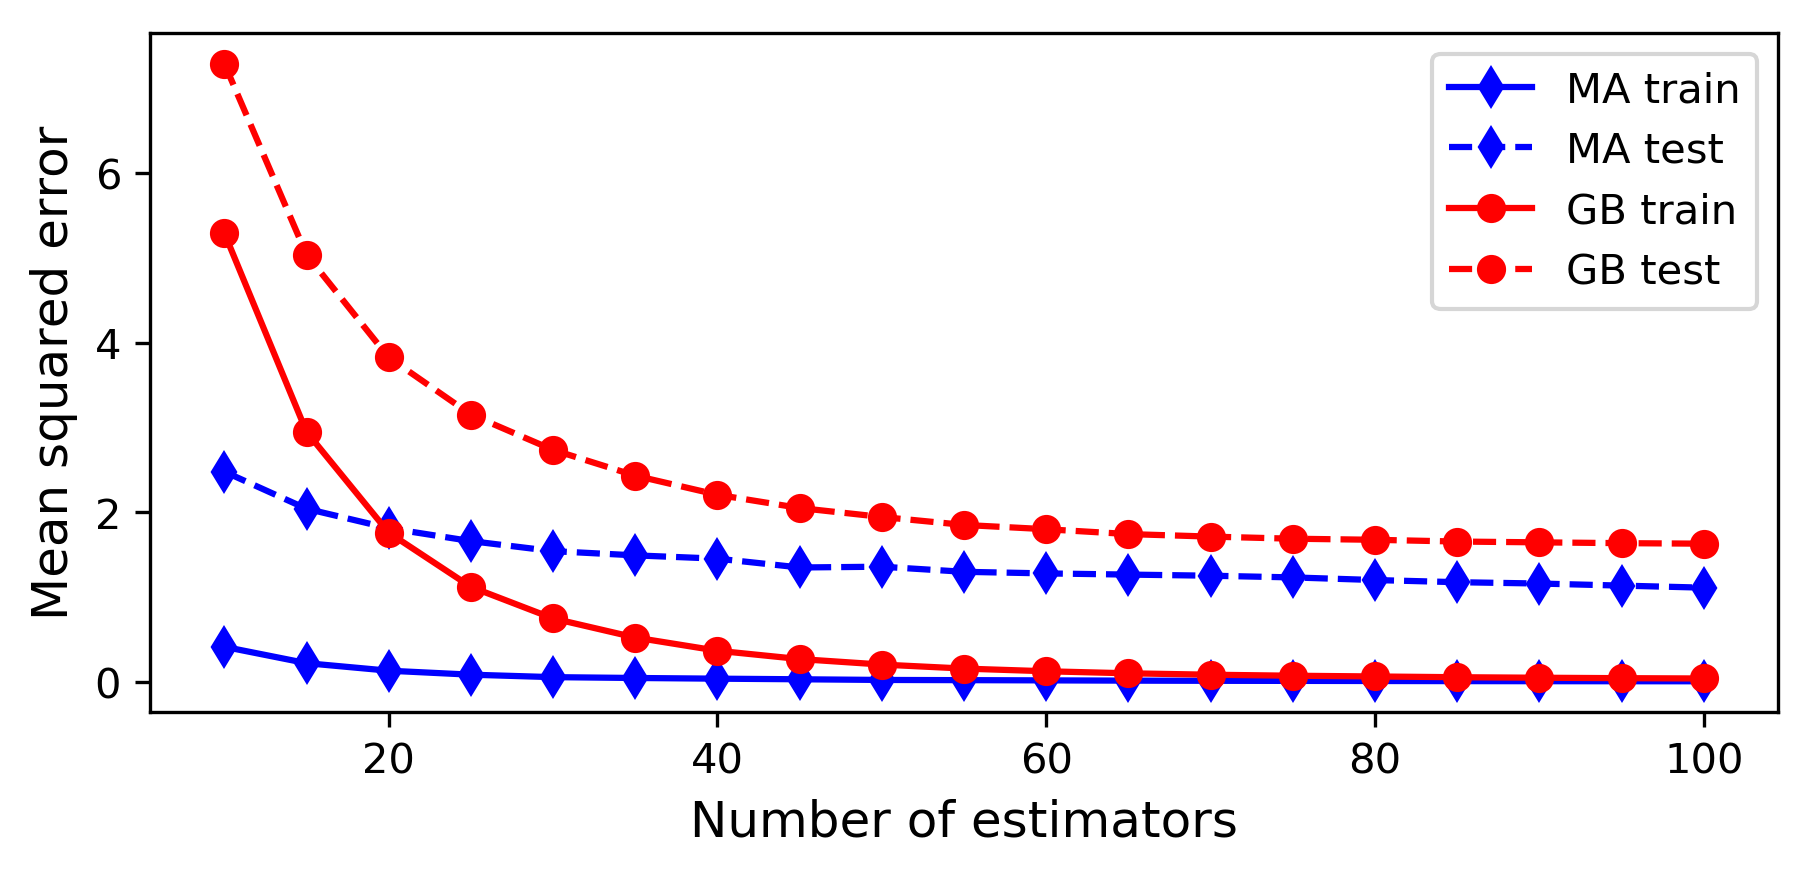

In [8]:
plt.figure(figsize=(7,3), dpi = 300)
plt.plot(n_est, ma_train, 'b', marker = 'd', label = 'MA train')
plt.plot(n_est, ma_test,'b--', marker = 'd', label = 'MA test')
plt.plot(n_est,gb_train,'r', marker = 'o', label = 'GB train')
plt.plot(n_est,gb_test,'r--',marker = 'o', label = 'GB test')
plt.legend()
plt.xlabel('Number of estimators', fontsize=12)
plt.ylabel('Mean squared error', fontsize=12)

##### 3.2. Trade off between tree depth and number of estimators (Fig. 3 in paper)

In [9]:
from mpl_toolkits.mplot3d import Axes3D 

In [10]:
# Managing Ambiguity
res = []
for d in range(1,11):
    res_d = []
    for n in range(25,105,5):
        ma = ManagingAmbiguityRegressor(base_estimator = DecisionTreeRegressor(max_depth = d, random_state = 101), n_estimators = n)
        res_test, res_train = cv_score(ma, X, y)
        res_d.append(res_test.mean())
    res.append(res_d)
ares_ma = np.array(res)

In [11]:
# Gradient Boosting
res = []
for d in range(1,11):
    res_d = []
    for n in range(25,105,5):
        gb = GradientBoostingRegressor(n_estimators = n, max_depth = d, random_state = 101)
        res_test, res_train = cv_score(gb, X, y)
        res_d.append(res_test.mean())
    res.append(res_d)
ares = np.array(res)

Text(0.5, 0.92, 'Gradient Boosting Regressor')

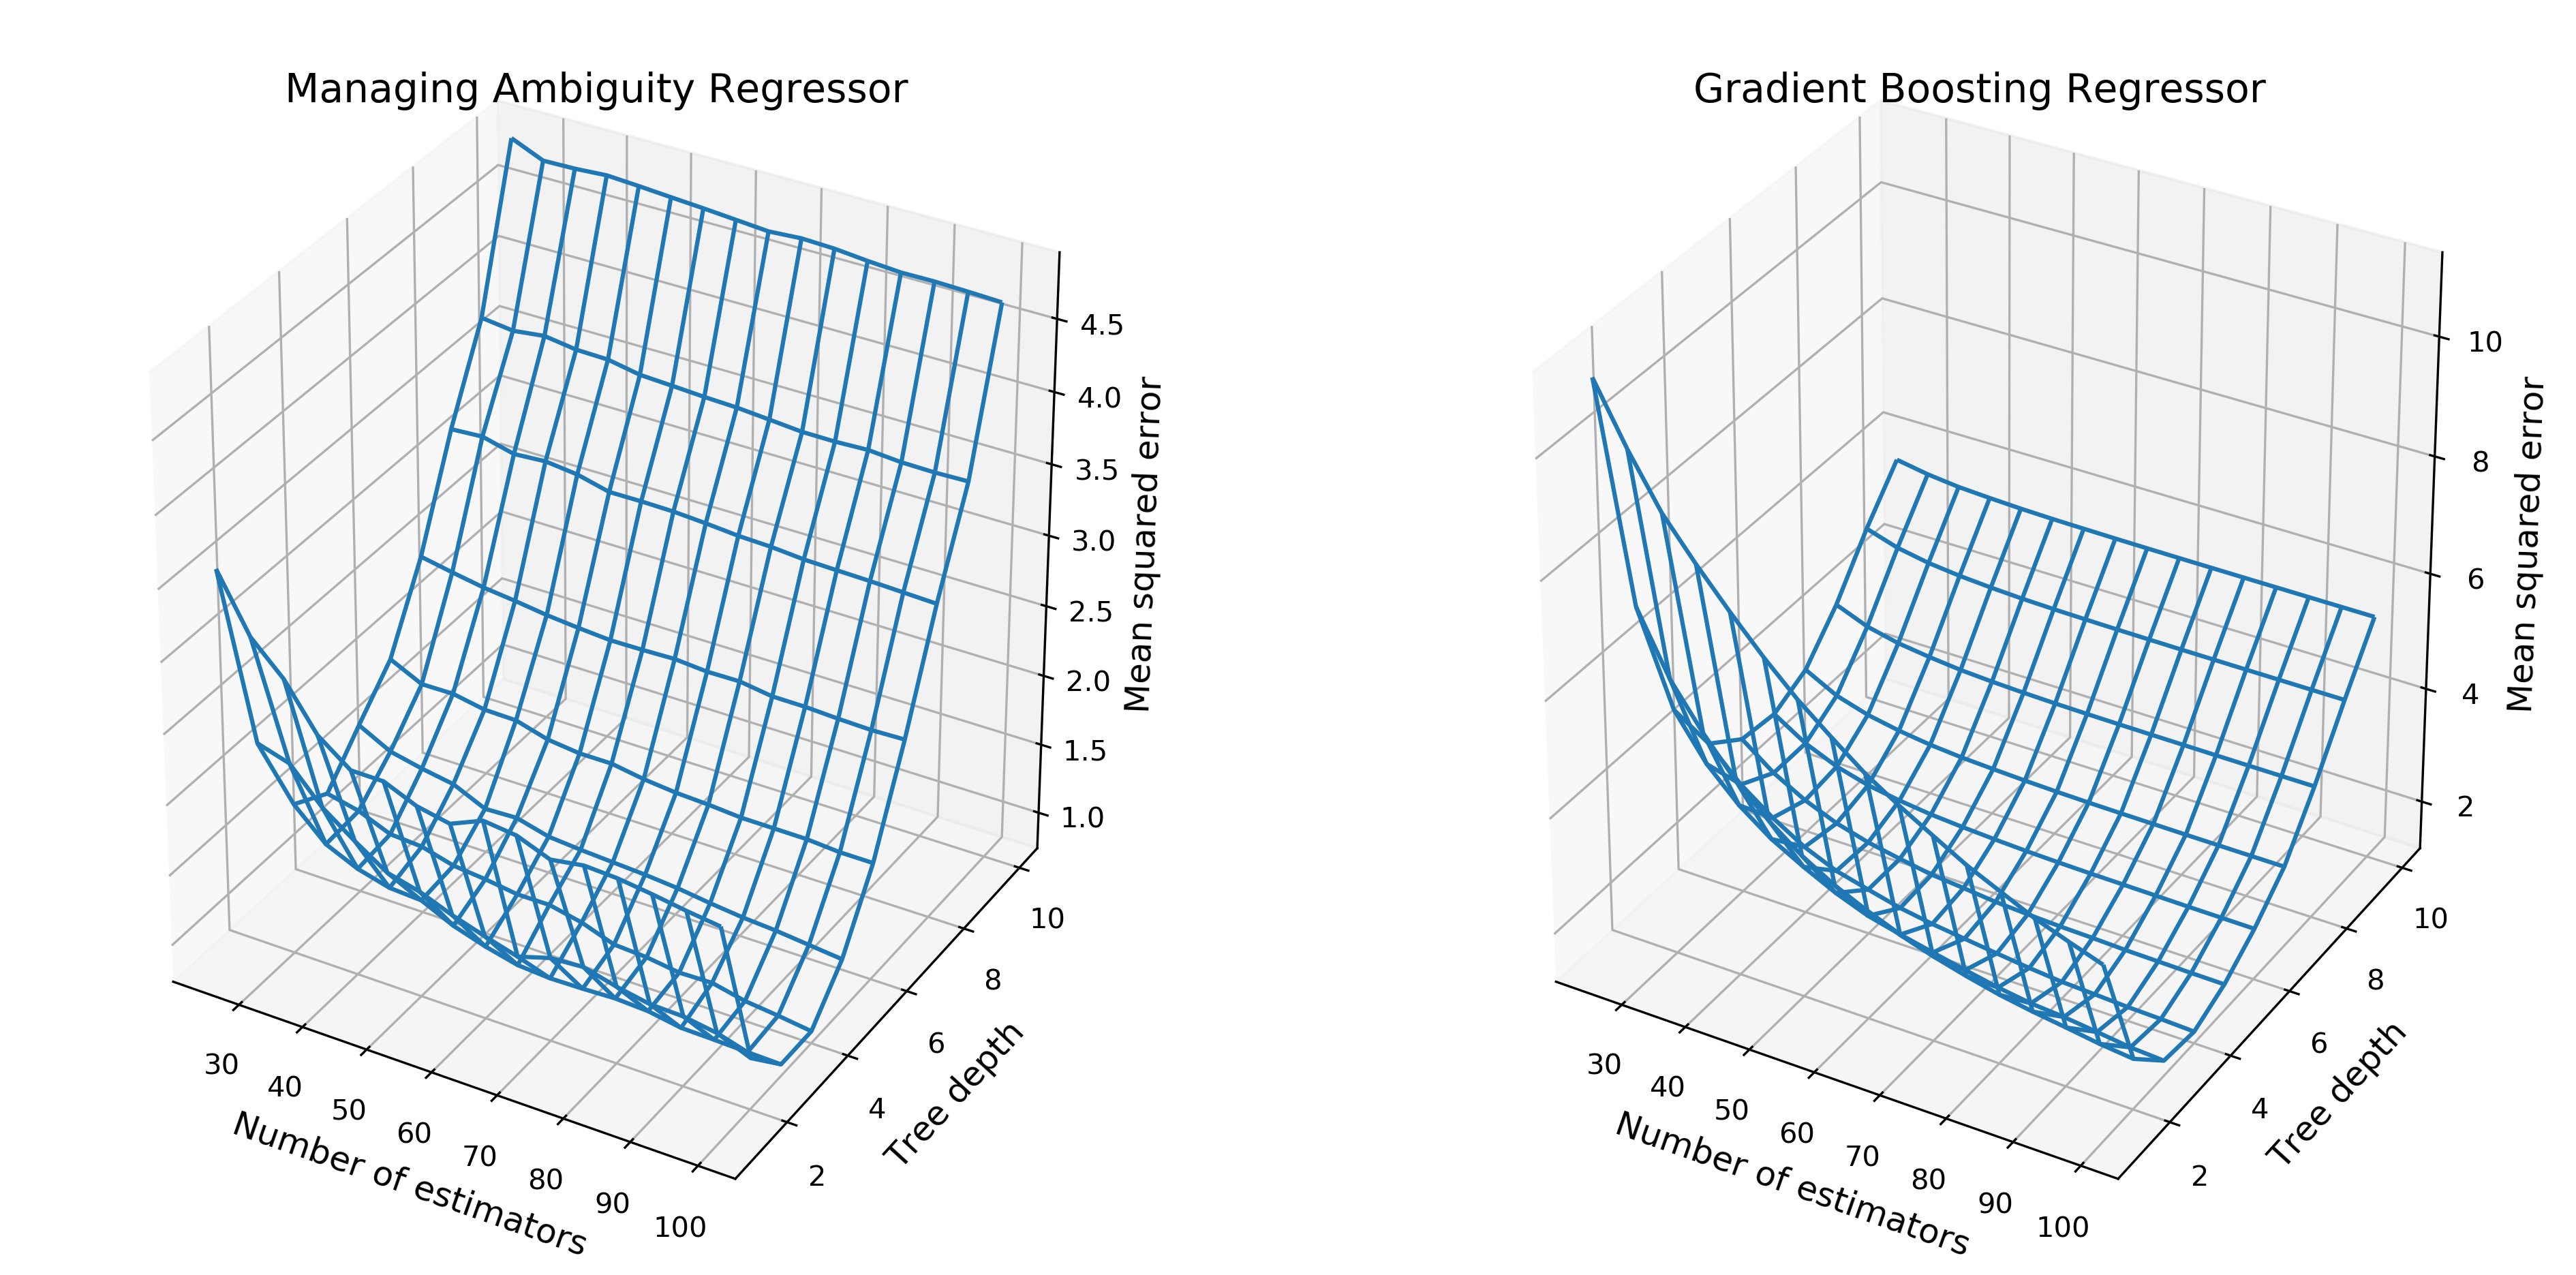

In [12]:
xx = np.array([n for n in range(25,105,5)])
yy = np.array([d for d in range(1,11)])

xx,yy = np.meshgrid(xx, yy)

fig = plt.figure(figsize = (16,8), dpi = 300)

ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(xx, yy, ares_ma) 
ax.set_xlabel('Number of estimators', fontsize = 12)
ax.set_ylabel('Tree depth', fontsize = 12)
ax.set_zlabel('Mean squared error', fontsize = 12)
ax.set_title('Managing Ambiguity Regressor', fontsize = 14)

ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(xx, yy, ares) 
ax.set_xlabel('Number of estimators', fontsize = 12)
ax.set_ylabel('Tree depth', fontsize = 12)
ax.set_zlabel('Mean squared error', fontsize = 12)
ax.set_title('Gradient Boosting Regressor', fontsize = 14)

In [13]:
# Minimal values
ind = np.unravel_index(np.argmin(ares_ma, axis=None), ares_ma.shape)
print('MA: better performance is %.3f when max_depth=%1d and n_estimators=%2d'  %(ares_ma[ind],yy[ind],xx[ind]))
ind = np.unravel_index(np.argmin(ares, axis=None), ares.shape)
print('GB: better performance is %.3f when max_depth=%1d and n_estimators=%2d'  %(ares[ind],yy[ind],xx[ind]))

MA: better performance is 0.821 when max_depth=3 and n_estimators=100
GB: better performance is 1.366 when max_depth=4 and n_estimators=100


#### 4. Visualuzation (Fig. 4 - 6 in paper)

In [14]:
# Creating synthetic dataset according to
# J. Friedman, “Multivariate adaptive regression splines”, The Annals of Statistics 19 (1), pages 1-67, 1991

X, y = make_friedman1(n_samples=7500, n_features=20, noise=0.1, random_state=1)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state= 2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7500, 20) (7500,)
(5625, 20) (5625,)
(1875, 20) (1875,)


In [15]:
n = 20

models = {'rf' : RandomForestRegressor(n_estimators = n, random_state = 101), 
          'br' : BaggingRegressor(n_estimators = n, random_state = 101), 
          'ma' : ManagingAmbiguityRegressor(base_estimator = DecisionTreeRegressor(max_depth = 5, random_state = 101), n_estimators = n),
          'gb' : GradientBoostingRegressor(n_estimators = n, max_depth = 5, random_state = 101)} 

for name in models:
    models[name].fit(X_train, y_train)
    print('%2s: %6.3f %6.3f' %(name, mean_squared_error(y_train, models[name].predict(X_train)),
                                     mean_squared_error(y_test, models[name].predict(X_test))))

rf:  0.326  1.844
br:  0.323  1.849
ma:  0.332  0.652
gb:  2.523  3.059


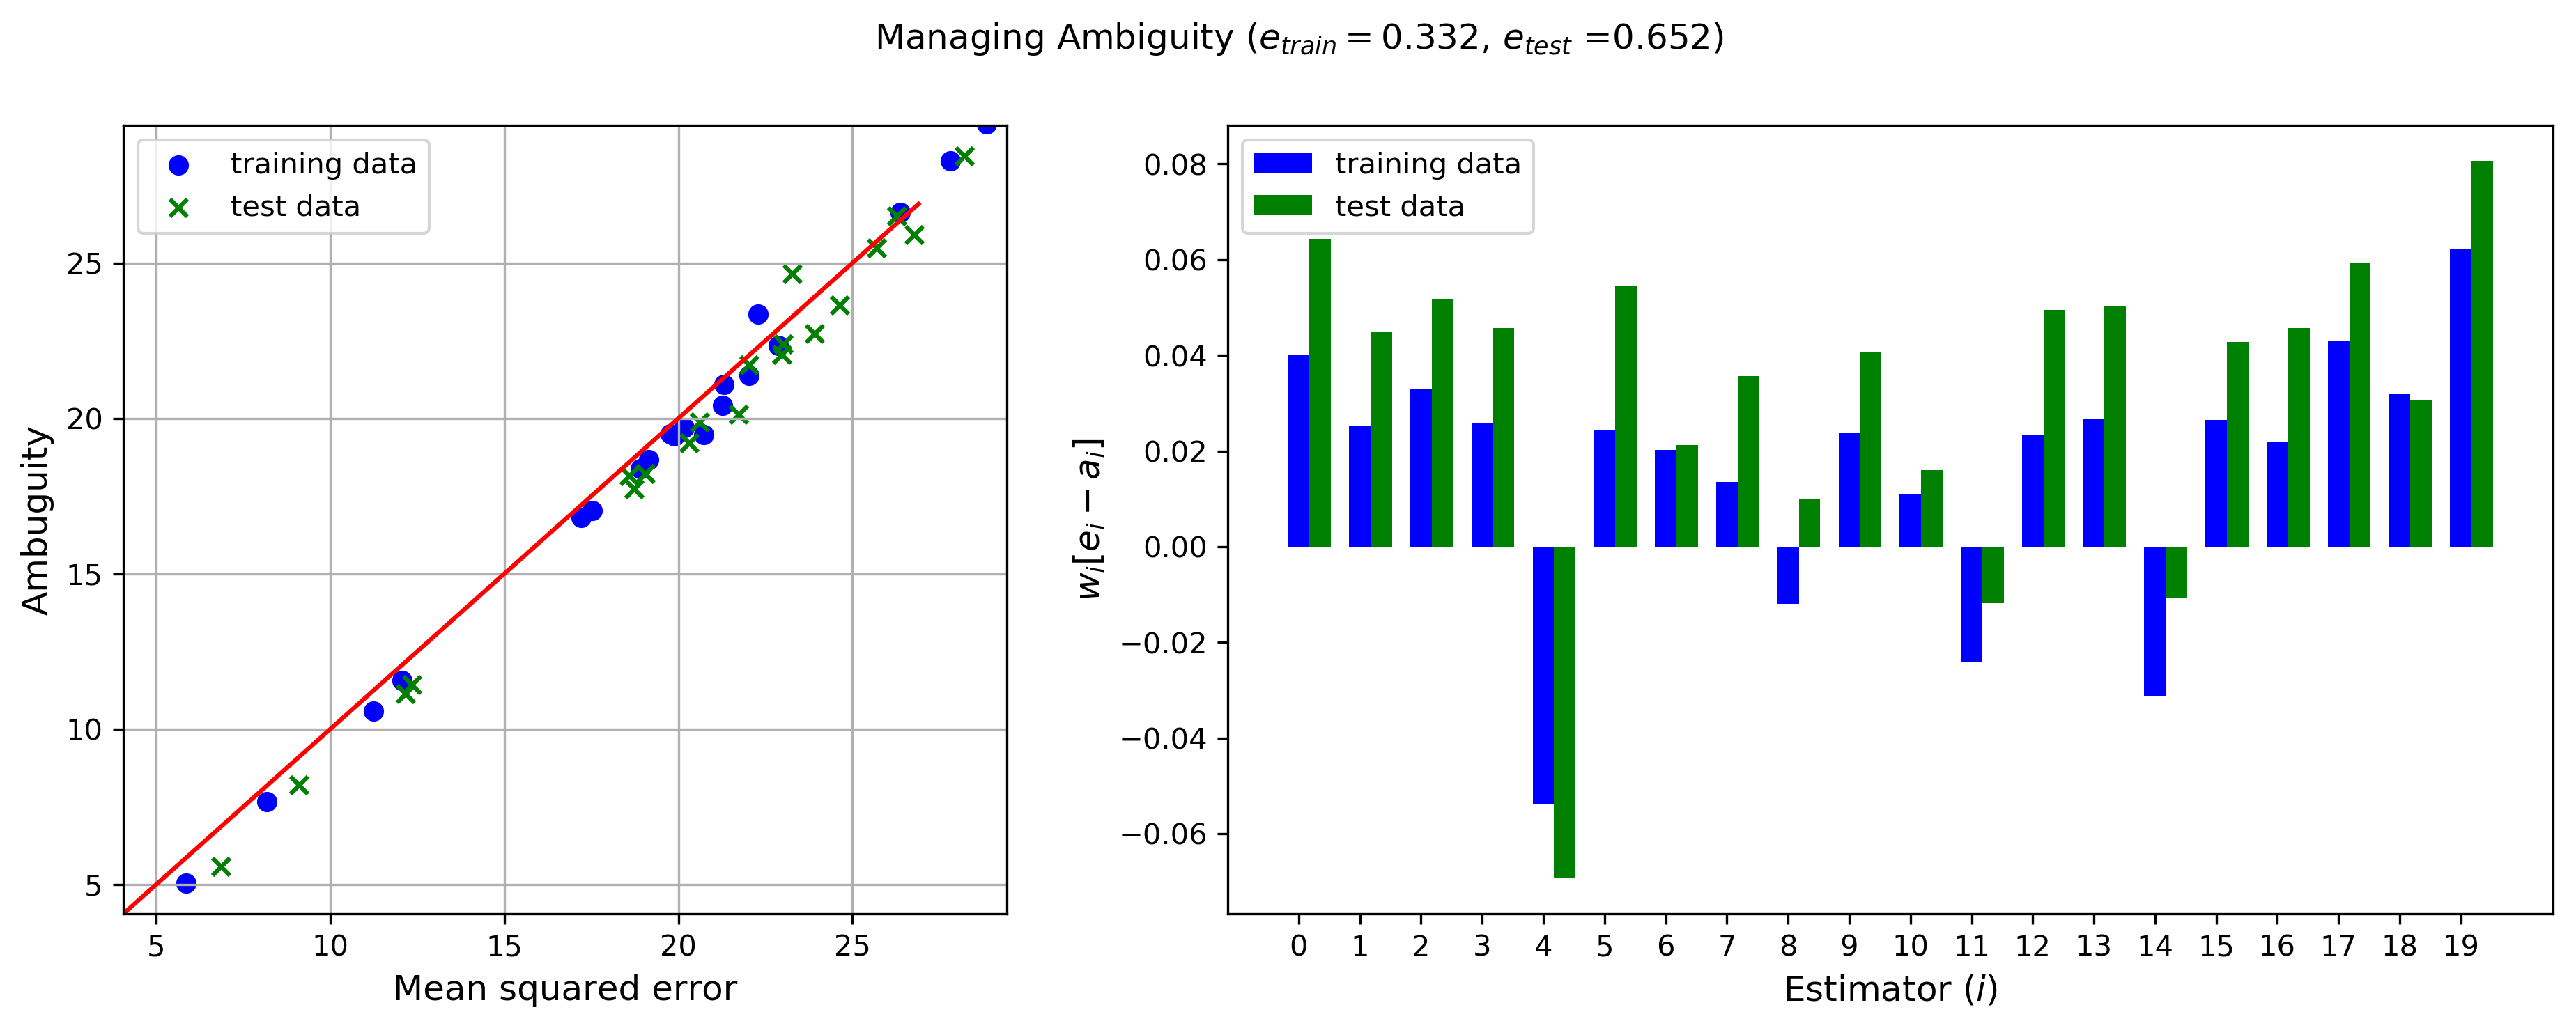

In [16]:
mse_amb_plot(models['ma'],'Managing Ambiguity', X_train, y_train, X_test, y_test)

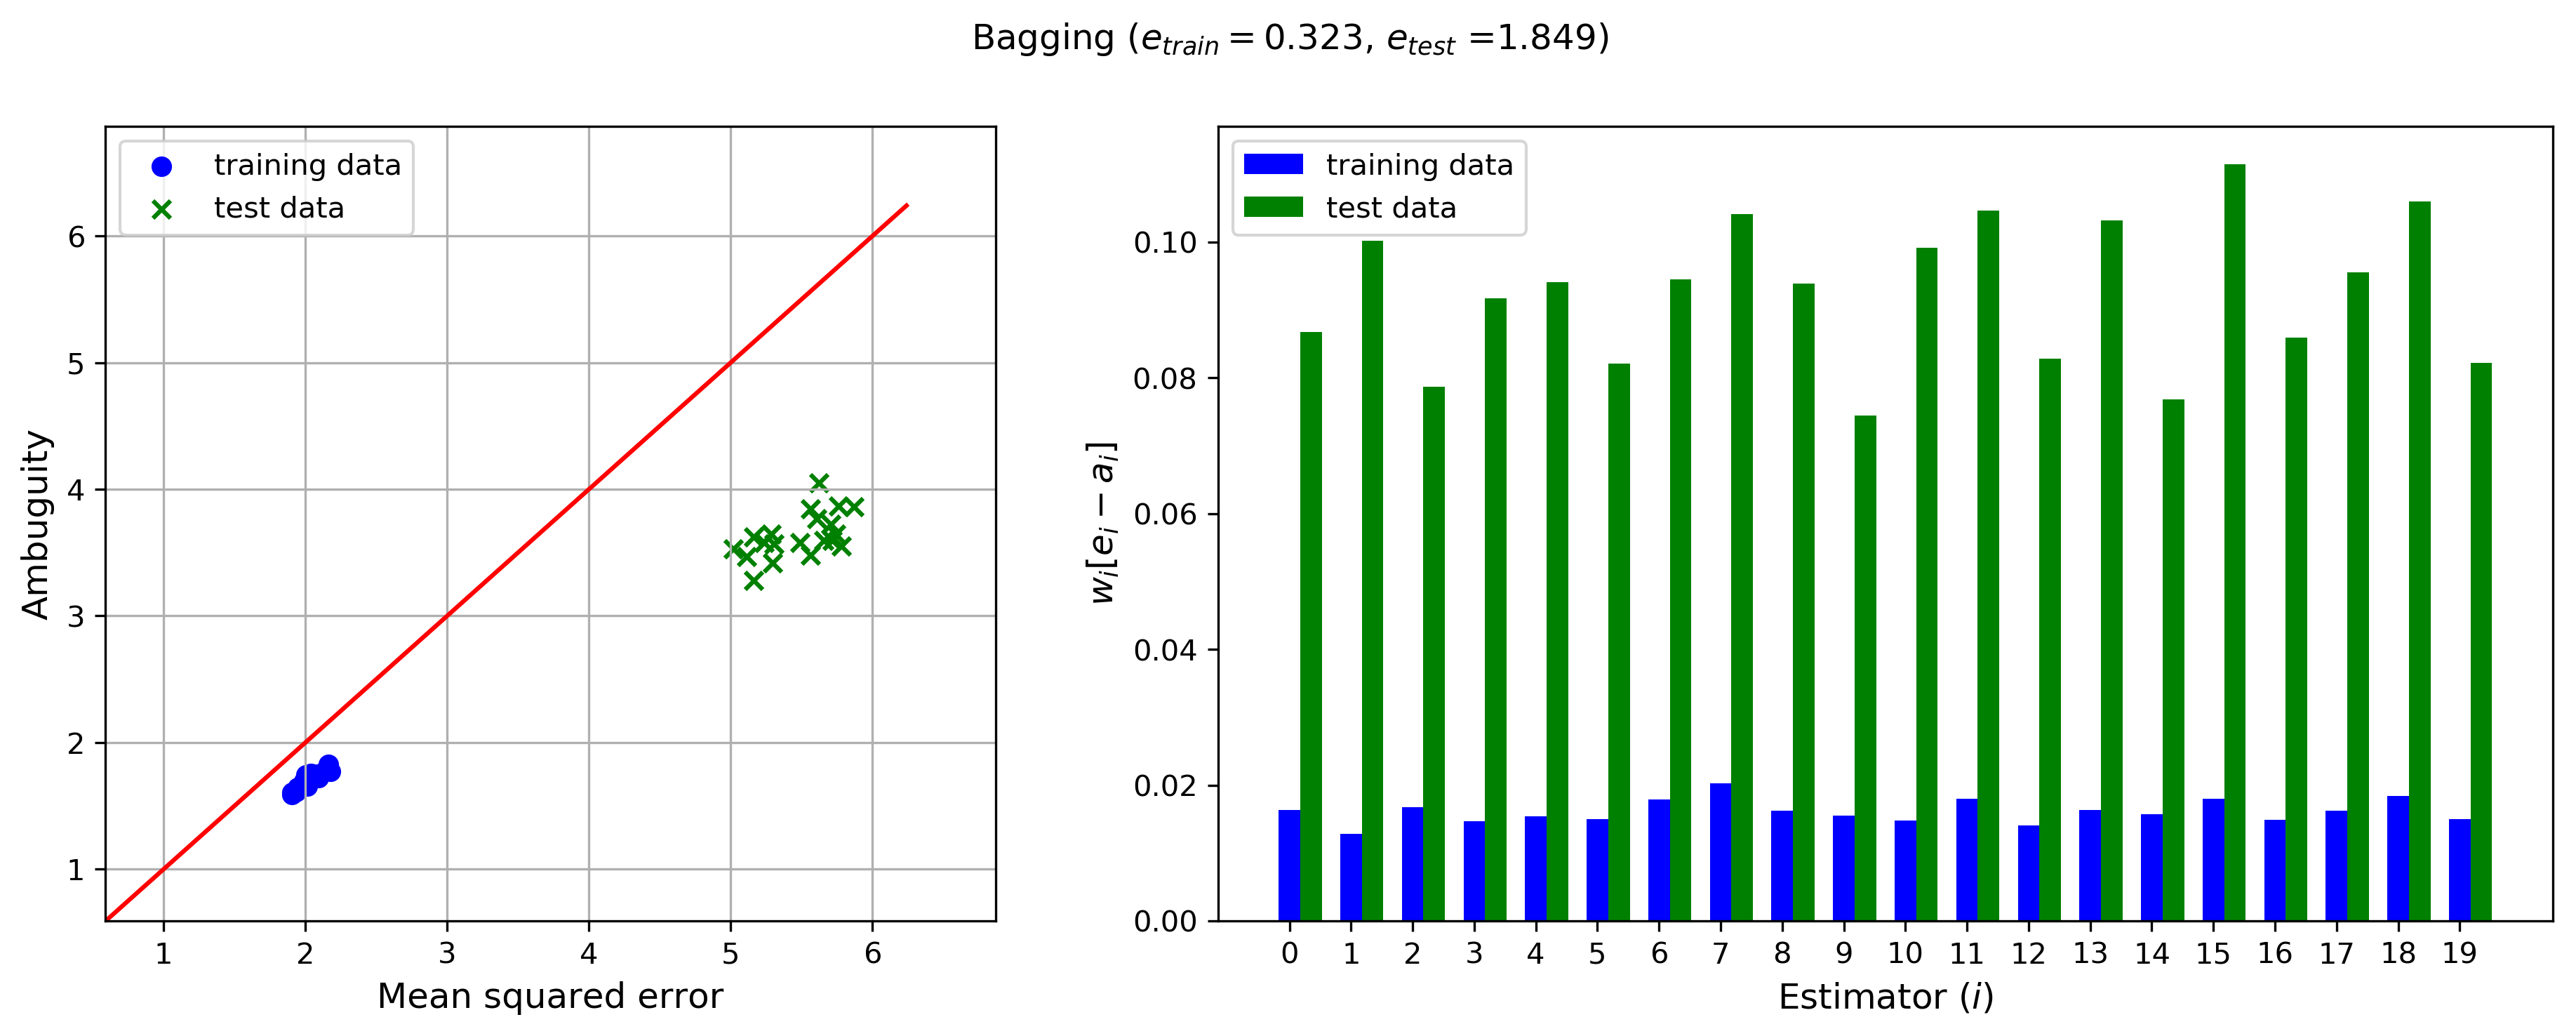

In [17]:
mse_amb_plot(models['br'],'Bagging', X_train, y_train, X_test, y_test)

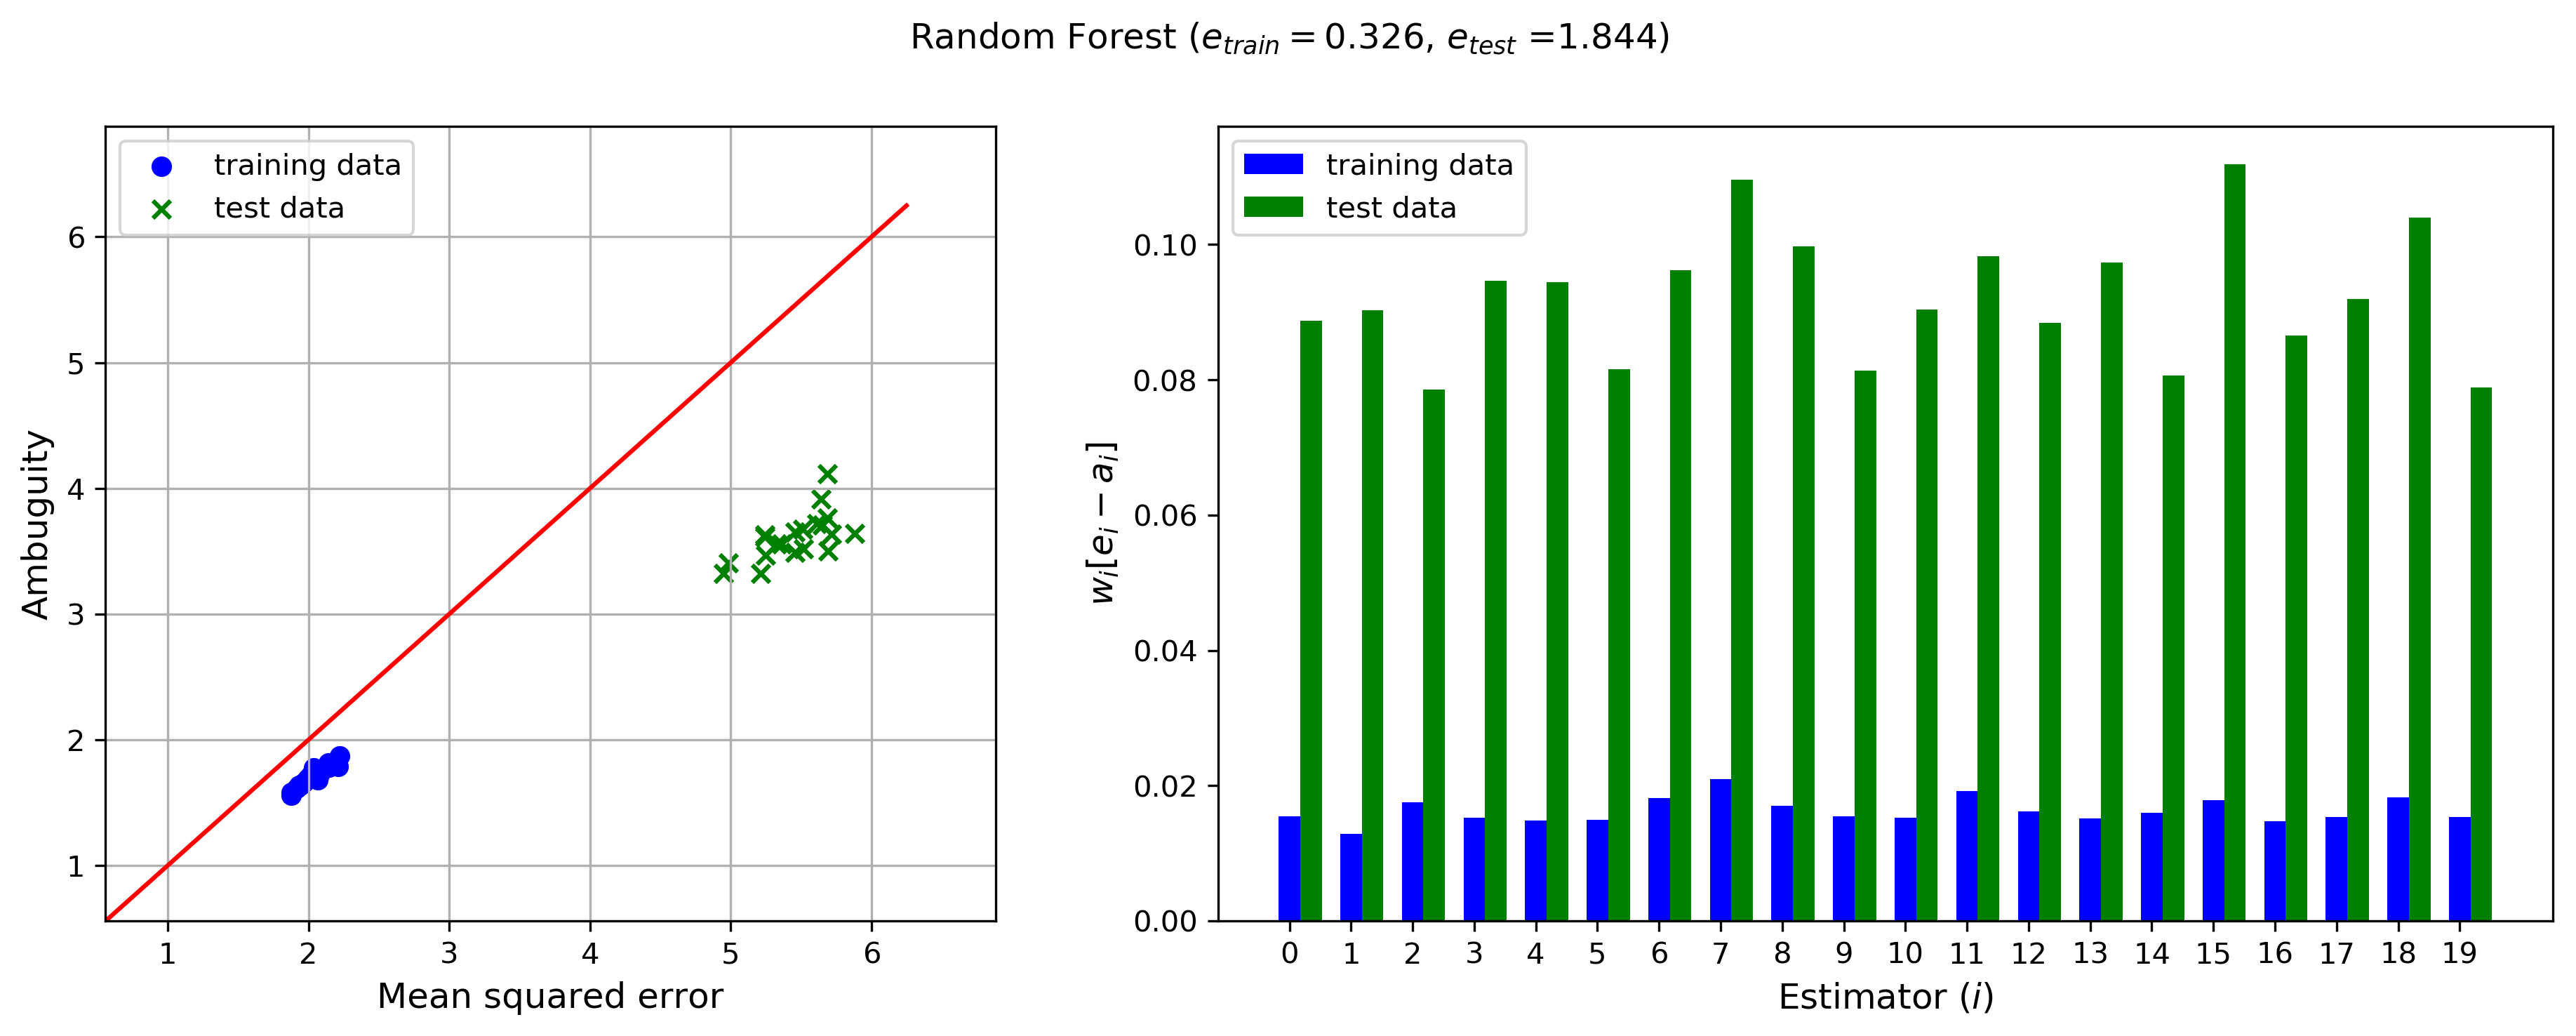

In [18]:
mse_amb_plot(models['rf'],'Random Forest', X_train, y_train, X_test, y_test)

#### Difference between two formulas for new target (Fig.1 in paper)

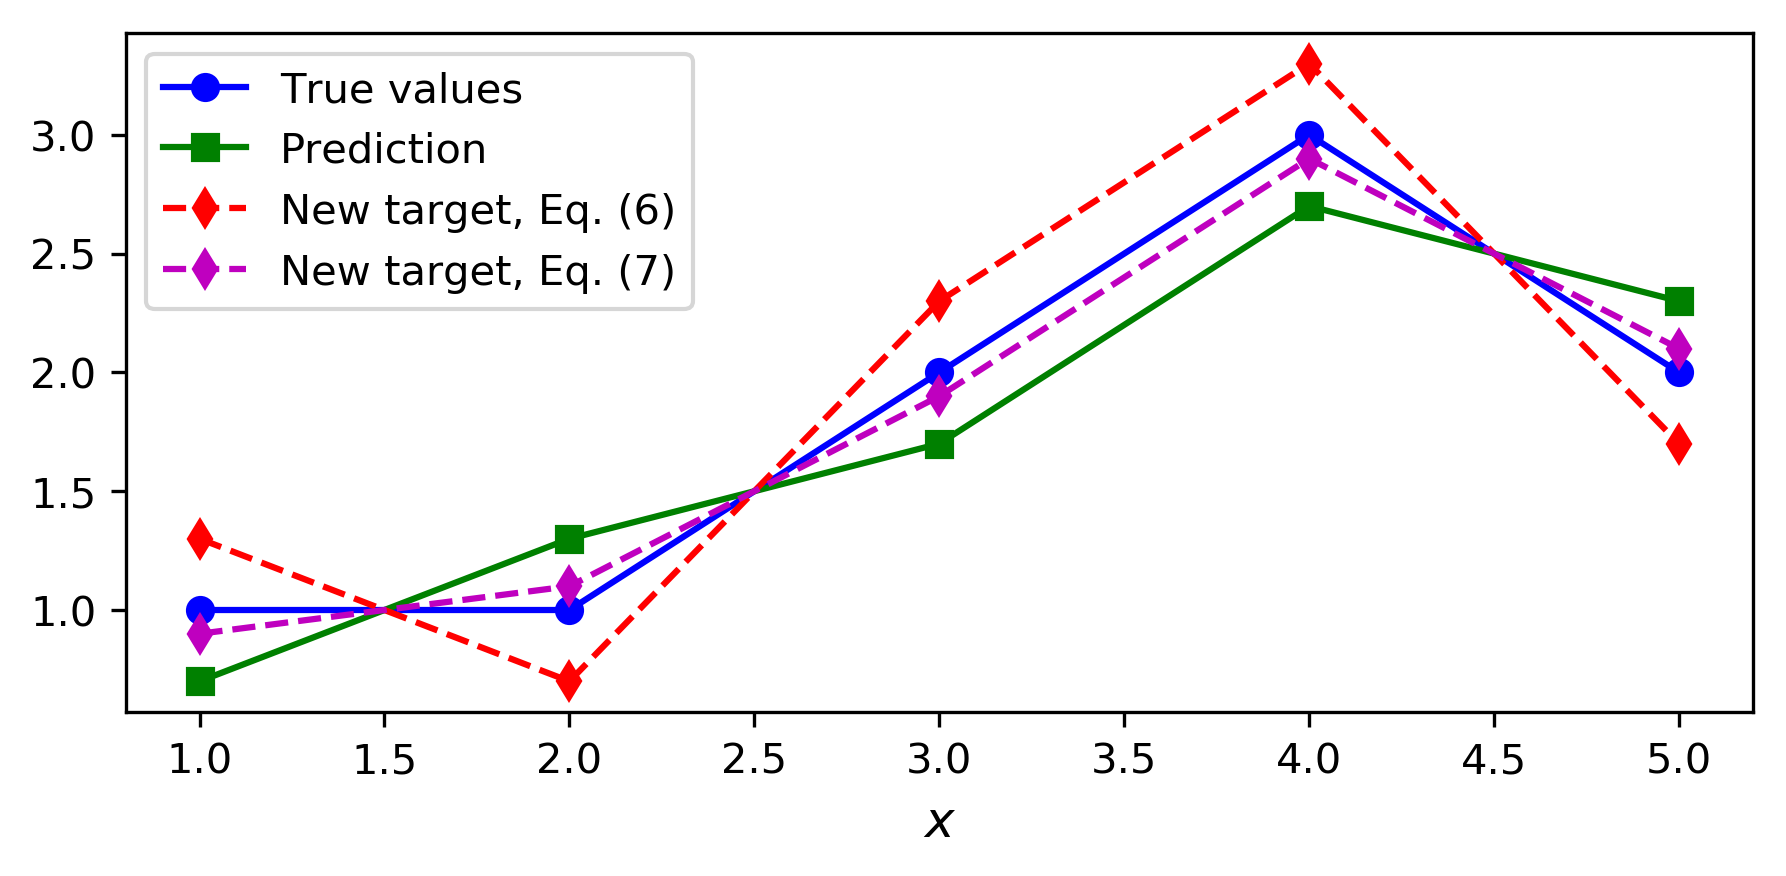

In [19]:
M = 2

xx = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
yy = np.array([1.0, 1.0, 2.0, 3.0, 2.0])
f  = np.array([0.7, 1.3, 1.7, 2.7, 2.3])

t1 = M * yy - f
t2 = (M * yy + f) / (2 * M - 1)

plt.figure(figsize=(7,3), dpi = 300)
plt.plot(xx,yy,'b', marker = 'o', label = 'True values')
plt.plot(xx,f, 'g', marker = 's', label = 'Prediction')
plt.plot(xx,t1,'r--', marker = 'd', label = 'New target, Eq. (6)')
plt.plot(xx,t2,'m--', marker = 'd', label = 'New target, Eq. (7)')
plt.xlabel('$x$', fontsize=12)
plt.legend()

#### 5.Experiments with real datasets (Section 5 in paper)

| Dataset | No of feat| Samples | Link                                                                |
|---------|-----------|---------|---------------------------------------------------------------------|
| AEP     |       26  |   19753 |https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction |
| Airfoil |        5  |    1503 |https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise           |
| Bike    |       12  |   17389 |https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset         |
| Boston  |       13  |     506 |https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html | 
| Cadata  |        8  |   20640 |http://lib.stat.cmu.edu/datasets/ |
| CASP    |        9  |   45730 |https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure|
| CCPP    |        4  |    9568 |https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant |
| News    |       58  |   39644 |https://archive.ics.uci.edu/ml/datasets/online+news+popularity |
| PM2.5   |       14  |   41757 |https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data |
| SC      |       81  |   21263 |https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data |

In [20]:
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

In [21]:
n = 50
d = 3

gb = GradientBoostingRegressor(n_estimators = n, max_depth = d, random_state = 101)
ma = ManagingAmbiguityRegressor(base_estimator = DecisionTreeRegressor(max_depth = d, random_state = 101), n_estimators = n)
rf = RandomForestRegressor(n_estimators = n, max_depth = d, random_state = 101)
br = BaggingRegressor(base_estimator = DecisionTreeRegressor(max_depth = d), n_estimators = n, random_state = 101)

def baseline(X,y):
    
    models = [gb,ma, rf, br]
    names = ['GB', 'MA', 'RF', 'BR']
    
    for model, name in zip(models,names):
        start = time()
        res_test, res_train = cv_score(model,X,y)
        print('%3s: train: %.2f (%.2f) test: %.2f (%.2f) time: %6.2f' 
              %(name,res_train.mean(), res_train.std(), res_test.mean(), res_test.std(), time() - start))

In [22]:
# AEP: Appliances energy prediction
df = pd.read_csv('AEP/energydata_complete.csv')
print(df.shape) 

aep = Dataset(df.drop(['date','Appliances','lights'], axis = 1).values, df['Appliances'].values)
print(aep.X.shape, aep.y.shape)

baseline(aep.X, aep.y)

(19735, 29)
(19735, 26) (19735,)
 GB: train: 7693.99 (534.88) test: 15223.203 (5191.64) time:   5.84
 MA: train: 5553.77 (371.76) test: 33485.108 (22312.15) time:  24.36
 RF: train: 9314.54 (645.26) test: 13659.356 (3705.75) time:  11.31
 BR: train: 9313.61 (644.48) test: 13601.436 (3667.18) time:  12.70


In [23]:
# Airfoil
df = pd.read_table('Airfoil/airfoil_self_noise.dat.txt', delim_whitespace = True, names = ['Frequency','Angle','Chord','Velocity','Tickeness','Sound'])
print(df.shape)

airfoil = Dataset(df.drop(['Sound'],axis=1).values, df['Sound'].values)
print(airfoil.X.shape, airfoil.y.shape)

baseline(airfoil.X, airfoil.y)

(1503, 6)
(1503, 5) (1503,)
 GB: train: 7.75 (0.92) test: 19.207 (5.59) time:   0.14
 MA: train: 2.82 (0.44) test: 18.210 (7.45) time:   0.91
 RF: train: 19.19 (2.03) test: 30.194 (8.12) time:   0.32
 BR: train: 19.20 (2.03) test: 30.249 (8.16) time:   0.37


In [24]:
# Bike Sharing
bike_sharing = pd.read_csv("BikeSharing/hour.csv")
print(bike_sharing.shape)

bike = Dataset(bike_sharing.drop(['instant','dteday','cnt','casual','registered'], axis = 1).values, bike_sharing.cnt.values)
print(bike.X.shape, bike.y.shape)

baseline(bike.X, bike.y)

(17379, 17)
(17379, 12) (17379,)
 GB: train: 7443.63 (1162.76) test: 9060.414 (4243.12) time:   1.56
 MA: train: 2925.28 (358.59) test: 4535.852 (2054.91) time:   5.17
 RF: train: 15429.37 (2526.52) test: 18687.546 (5641.51) time:   1.81
 BR: train: 15427.82 (2527.43) test: 18679.854 (5632.96) time:   2.18


In [25]:
# Boston Houses prices

X, y = load_boston(return_X_y=True)

boston = Dataset(X, y)
print(boston.X.shape, boston.y.shape)

baseline(boston.X, boston.y)

(506, 13) (506,)
 GB: train: 2.96 (0.22) test: 21.125 (11.78) time:   0.17
 MA: train: 0.68 (0.07) test: 21.708 (8.82) time:   0.92
 RF: train: 9.83 (1.18) test: 26.715 (12.59) time:   0.36
 BR: train: 9.82 (1.20) test: 26.716 (12.51) time:   0.40


In [26]:
# Cadata: California housing
columnNames = ['HouseVal','MedInc','HouseAge','TotalRooms',
               'TotalBedrms','Population','AveOccup','Latitude','Longitude']

df = pd.read_csv('CaliforniaHousing/cadata.csv', skiprows=27, sep=',', names=columnNames, index_col = False)
print(df.shape)

cadata = Dataset(df.drop(['HouseVal'], axis = 1).values, df.HouseVal.values / 1000)
print(cadata.X.shape, cadata.y.shape)

baseline(cadata.X, cadata.y)

(20614, 9)
(20614, 8) (20614,)
 GB: train: 3392.88 (145.49) test: 5604.326 (1064.67) time:   1.88
 MA: train: 2275.20 (72.56) test: 4922.834 (1162.36) time:   7.99
 RF: train: 6186.90 (341.30) test: 7714.840 (1859.19) time:   3.58
 BR: train: 6186.91 (341.33) test: 7714.367 (1858.55) time:   3.96


In [27]:
# CASP: Physicochemical Properties of Protein Tertiary Structure
df = pd.read_csv('CASP/CASP.csv')
print(df.shape)

casp = Dataset(df.drop(['RMSD'], axis = 1).values, df['RMSD'].values)
print(casp.X.shape, casp.y.shape)

baseline(casp.X, casp.y)

(45730, 10)
(45730, 9) (45730,)
 GB: train: 23.53 (0.10) test: 24.037 (0.46) time:   9.48
 MA: train: 18.87 (0.07) test: 20.262 (0.39) time:  31.18
 RF: train: 28.72 (0.16) test: 28.884 (0.56) time:  15.61
 BR: train: 28.72 (0.16) test: 28.883 (0.56) time:  15.95


In [28]:
# CCPP: Combined Cycle Power Plant Data Set
df = pd.read_excel('CCPP/Folds5x2_pp.xlsx')
print(df.shape)

ccpp = Dataset(df.drop(['PE'], axis = 1).values, df['PE'].values)
print(ccpp.X.shape, ccpp.y.shape)

baseline(ccpp.X, ccpp.y)

(9568, 5)
(9568, 4) (9568,)
 GB: train: 14.99 (0.28) test: 16.076 (0.69) time:   0.77
 MA: train: 11.92 (0.33) test: 14.047 (0.60) time:   3.44
 RF: train: 23.09 (0.31) test: 23.785 (1.02) time:   1.38
 BR: train: 23.10 (0.31) test: 23.786 (1.02) time:   1.51


In [29]:
# News: Online News Popularity Data Set

df = pd.read_csv('News/OnlineNewsPopularity.csv')
print(df.shape)

news = Dataset(df.drop(['url',' timedelta',' shares'], axis = 1).values, df[' shares'].values/1000)
print(news.X.shape, news.y.shape)

baseline(news.X, news.y)

(39644, 61)
(39644, 58) (39644,)
 GB: train: 92.24 (17.87) test: 139.270 (63.91) time:  33.37
 MA: train: 60.68 (13.09) test: 162.424 (58.00) time:  97.13
 RF: train: 112.80 (21.28) test: 136.395 (62.44) time:  43.92
 BR: train: 112.88 (21.26) test: 136.652 (62.75) time:  48.27


In [30]:
# PM2.5: Beijing PM2.5 Data Set

df = pd.read_csv('PM2.5/PRSA_data_2010.1.1-2014.12.31.csv')
print(df.shape)
df.dropna(inplace = True)
df = pd.get_dummies(df)
print(df.shape)

pm25 = Dataset(df.drop(['No', 'pm2.5'], axis = 1).values, df['pm2.5'].values)
print(pm25.X.shape, pm25.y.shape)

baseline(pm25.X, pm25.y)

(43824, 13)
(41757, 16)
(41757, 14) (41757,)
 GB: train: 4519.37 (111.92) test: 5247.190 (318.75) time:   4.62
 MA: train: 3161.68 (56.59) test: 4789.930 (225.65) time:  14.48
 RF: train: 6320.79 (153.26) test: 6616.587 (540.16) time:   4.73
 BR: train: 6320.97 (152.71) test: 6616.915 (540.19) time:   6.76


In [31]:
# Superconductivity Data Set
df = pd.read_csv('Supercond/train.csv')
print(df.shape)

sc = Dataset(df.drop(['critical_temp'], axis = 1).values, df['critical_temp'].values)
print(sc.X.shape, sc.y.shape)

baseline(sc.X, sc.y)

(21263, 82)
(21263, 81) (21263,)
 GB: train: 173.23 (35.92) test: 223.861 (124.62) time:  24.19
 MA: train: 111.34 (26.65) test: 207.003 (101.57) time:  86.70
 RF: train: 329.80 (72.10) test: 352.993 (219.81) time:  41.48
 BR: train: 329.78 (72.08) test: 353.010 (219.79) time:  44.69
